In [46]:
!pip install adjustText

In [0]:
#################################
###  Authenticate Google Acc  ###
#################################

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
################################
###  Read Passwords Dataset  ###
################################

import pandas as pd
import numpy as np


# Dataset file of 1000 passwords
link = "https://drive.google.com/file/d/1RtN9pFpcIcvQozageptYRfVCDbIsYA-3/view"

file_id = link.split('/')[5]

downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('passwords.csv')  
passwords = pd.read_csv('passwords.csv', dtype={'Numeric': str})

In [0]:
##################################
###  Pad & Tokenize Passwords  ###
##################################
from keras.utils import to_categorical
from keras.preprocessing import sequence

# Identify max password length in dataset and pad rest of the passwords such that all of them have the same length.
# Haveing same length sequences is a requirement for LSTM
PAD_CHAR = "~"
PASS_LENGTH = max([len(p) for p in passwords["FullPassword"]])

padded_passwords = []
charset = set(PAD_CHAR)               # start with the initial padding char
for p in passwords["FullPassword"]:
  padded_passwords.append(p.ljust(PASS_LENGTH, PAD_CHAR))
  charset |= set(p)                   # |= is the union set operation.

# Convert characters to integers 
vocab_size = len(charset)
char2id = dict((c, i) for i, c in enumerate(charset))

# One hot encode the passwords
encoded_passwords = [[char2id[c] for c in password] for password in padded_passwords]
one_hot_encoded = np.array([to_categorical(p, num_classes=vocab_size) for p in encoded_passwords])


In [0]:
##################################
###  Create Autoencoder Model  ###
##################################
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, Bidirectional
from keras.models import Model

def create_lstm_autoencoder(timesteps, layer_sizes, vocab_size):
  """
  Creates a symmetric LSTM autoencoder model and returns, the autoencoder model, encoder model,
  and decoder model to be used individually.
  """
  # Create encoder model
  enc_input = Input(shape=(timesteps, vocab_size))
  x = enc_input
  for idx, layer_size in enumerate(layer_sizes):
    ret_seq = (idx != len(layer_sizes) - 1) # False for the last layer_size
    x = Bidirectional(LSTM(layer_size, return_sequences=ret_seq))(x)
  enc_output = Dense(layer_sizes[-1], activation="relu")(x)
  encoder = Model(enc_input, enc_output, name="Encoder")

  # Create decoder model
  bottleneck_size = layer_sizes[-1]
  dec_input = Input((bottleneck_size,))
  x = RepeatVector(timesteps)(dec_input)
  for layer_size in layer_sizes[::-1][1:]:
    x = Bidirectional(LSTM(layer_size, return_sequences=True))(x)
  dec_output = TimeDistributed(Dense(vocab_size, activation="softmax"))(x)
  decoder = Model(dec_input, dec_output, name="Decoder")

  # Connect decoder with encoder
  connected_decoder = decoder(enc_output)

  # Create autoencoder model
  autoencoder = Model(enc_input, connected_decoder, name="Autoencoder")
  autoencoder.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
  return encoder, decoder, autoencoder

In [17]:
encoder, decoder, autoencoder = create_lstm_autoencoder(PASS_LENGTH, [16, 10, 6], vocab_size)
encoder.summary()
decoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 15, 38)            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 15, 32)            7040      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 15, 20)            3440      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 12)                1296      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 78        
Total params: 11,854
Trainable params: 11,854
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Sh

In [18]:
#####################
###  Train Model  ###
#####################

autoencoder.fit(one_hot_encoded, one_hot_encoded, epochs=300, batch_size=10)

Epoch 1/300
1000/1000 [==============================] - 15s 15ms/step - loss: 2.9114 - acc: 0.3328
Epoch 2/300
1000/1000 [==============================] - 7s 7ms/step - loss: 2.1290 - acc: 0.4333
Epoch 3/300
1000/1000 [==============================] - 8s 8ms/step - loss: 1.7900 - acc: 0.4834
Epoch 4/300
1000/1000 [==============================] - 8s 8ms/step - loss: 1.5953 - acc: 0.5285
Epoch 5/300
1000/1000 [==============================] - 8s 8ms/step - loss: 1.4768 - acc: 0.5495
Epoch 6/300
1000/1000 [==============================] - 8s 8ms/step - loss: 1.3881 - acc: 0.5607
Epoch 7/300
1000/1000 [==============================] - 7s 7ms/step - loss: 1.3098 - acc: 0.5791
Epoch 8/300
1000/1000 [==============================] - 8s 8ms/step - loss: 1.2345 - acc: 0.6059
Epoch 9/300
1000/1000 [==============================] - 8s 8ms/step - loss: 1.1675 - acc: 0.6361
Epoch 10/300
1000/1000 [==============================] - 8s 8ms/step - loss: 1.1081 - acc: 0.6673
Epoch 11/300
1000

In [0]:
# Recosntruct passwords through autoencoder as vectors
reconst_passwd_vecs = autoencoder.predict(one_hot_encoded)
# Reverse one hot encoding to covnert passwords to strings
unpad = lambda text: text.replace(PAD_CHAR, "")
one_hot_decode = lambda one_hot_vectors: "".join([list(charset)[np.argmax(vec)] for vec in one_hot_vectors])
reconst_passwd_str = [unpad(one_hot_decode(p)) for p in reconst_passwd_vecs]

In [20]:
# Compare original vs reconstructed passwords
passwords_df = pd.DataFrame(zip(passwords["FullPassword"], reconst_passwd_str),
                            columns = ['Original Password', 'Recosntructed Password'])
passwords_df.head(10)

,Original Password,Recosntructed Password
0,Acafe2019!,Acafe2019!
1,Ahyper2019!,Ahyper2019!
2,Pleet10!,Tleet10!
3,Ababe2!,Ababe2!
4,Tbingo1234*,Abingo1234*
5,Eleet2019@,Tleet2019@
6,Tninja123!,Aninja123!
7,Aninja777*,Aninja777*
8,Ababe101*,Ababe101*
9,Tbingo2019_,Abingo2019*


In [43]:
################################
###  Generate New Passwords  ###
################################
import random

# Feel free to change the latent space values as you like and explore what comes
# out from the decoder
new_passwords = []
for _ in range(20):
  latent_sample = np.array([[random.uniform(-1, 1) for _ in range(6)]])
  new_password_vec = decoder.predict(latent_sample)
  new_password_str = unpad(one_hot_decode(new_password_vec[0]))
  new_passwords.append(new_password_str)
new_passwords_df = pd.DataFrame(new_passwords, columns=["Password"])
new_passwords_df.head(10)

,Password
0,aaa444nnaaaaann
1,n44444nn000aa0n
2,aaackkeaaa20119
3,Appes20019
4,Annnnnnmmmmammm
5,hhhhhhh04444999
6,aaaakeaaaaaaaa9
7,haakerman11$
8,Ahackkrmaa2019@
9,Ahacerman12*!


Plotting t-SNE visualization...


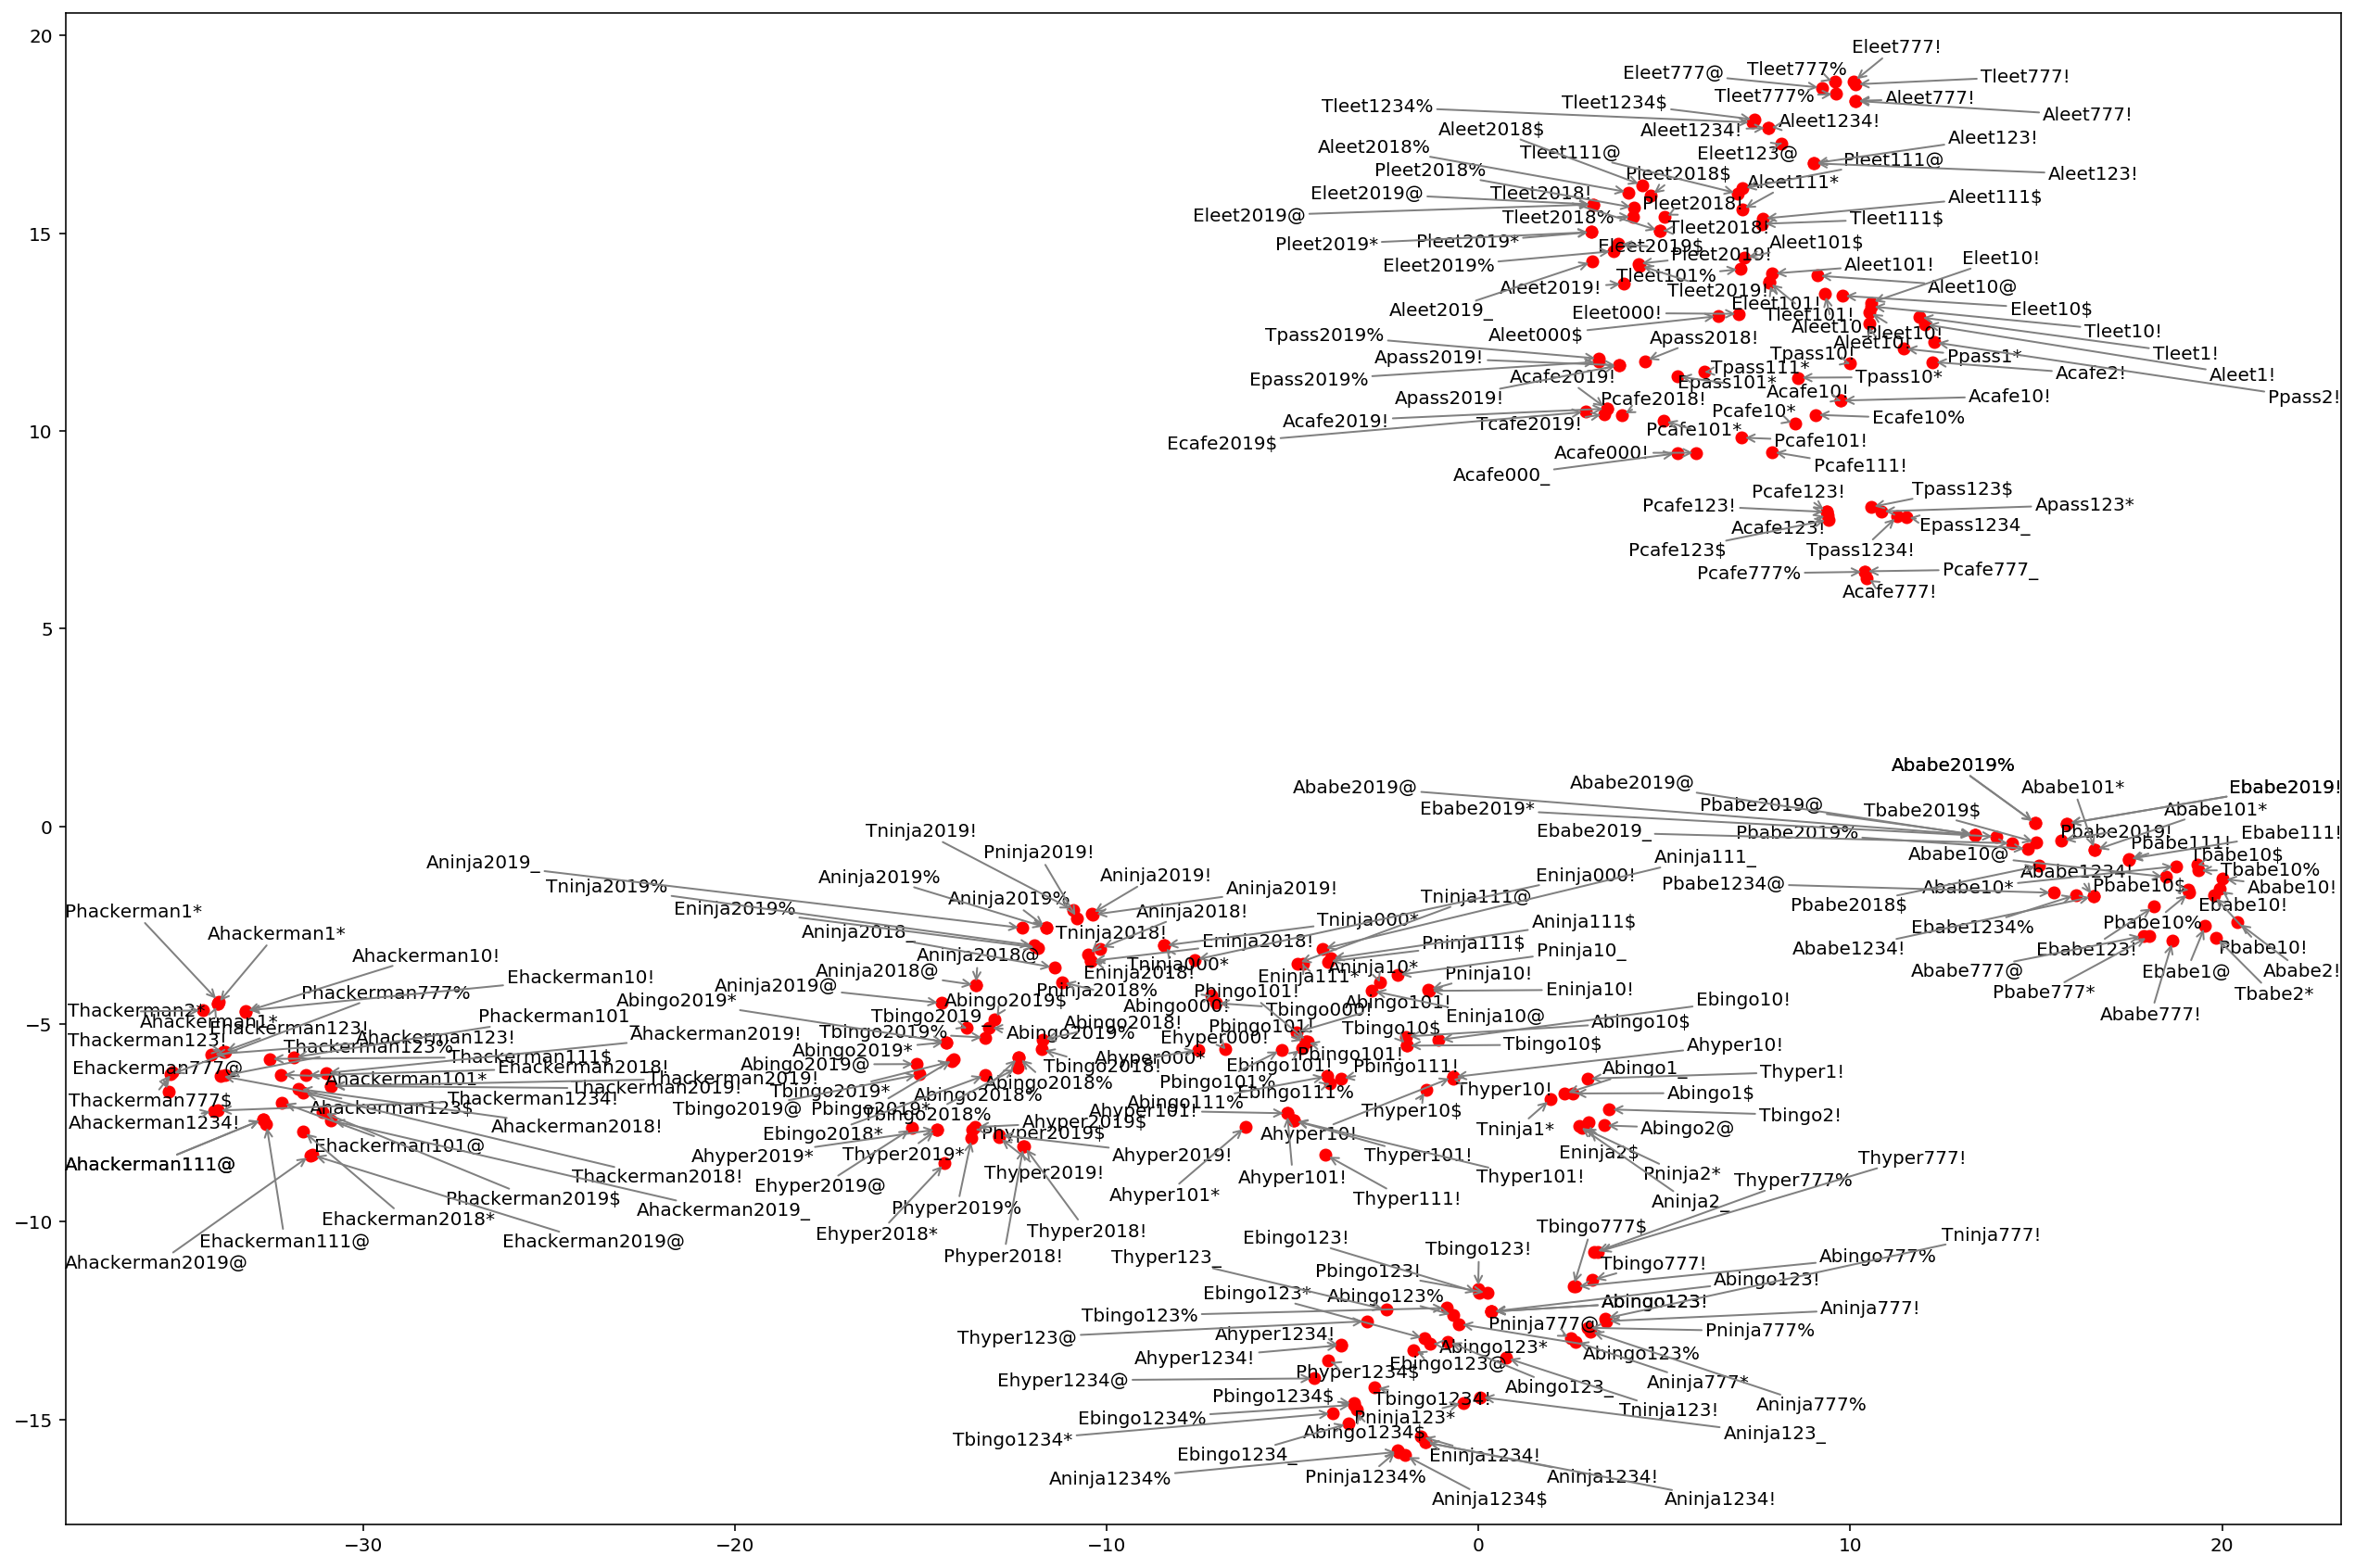

In [44]:
#############################################
###  Visualize Passowrds in Latent Space  ###
#############################################
%config InlineBackend.figure_format = 'retina'

from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, AnnotationBbox
from sklearn import manifold

def t_sne(latent_passwords, original_passwords, plot=True):
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(latent_passwords)
    if plot:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=(22,15))
        plt.plot(X_tsne[:, 0], X_tsne[:, 1], 'ro')
        texts = [plt.text(X_tsne[:, 0][i], X_tsne[:, 1][i], '%s' %original_passwords[i], ha='center', va='center') for i in range(len(original_passwords))]
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))
        plt.show()
    else:
        return X_tsne, tsne

limit = 300
latent_passwords = encoder.predict(one_hot_encoded[:limit])
t_sne(latent_passwords, passwords["FullPassword"][:limit])

# Variational Autoencoders

In [0]:
##########################
###  Create VAE Model  ###
##########################
from keras import objectives
from keras import backend as K
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, Lambda, Layer, Bidirectional
from keras.models import Model
import tensorflow as tf


def create_lstm_vae(timesteps, layer_sizes, vocab_size, epsilon_std=1.,
                    batch_size=10):
  """
  """
  def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(layer_sizes[-1],),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(.5 * z_log_sigma) * epsilon
  
  # Create encoder model
  enc_input = Input(batch_shape=(batch_size, timesteps, vocab_size))
  x = enc_input
  for idx, layer_size in enumerate(layer_sizes):
    ret_seq = (idx != len(layer_sizes) - 1) # False for the last layer_size
    x = Bidirectional(LSTM(layer_size, return_sequences=ret_seq))(x)
  enc_output = Dense(layer_sizes[-1], activation="relu")(x)
  z_mean = Dense(layer_sizes[-1])(enc_output)
  z_log_sigma = Dense(layer_sizes[-1])(enc_output)
  z = Lambda(sampling, output_shape=(layer_sizes[-1],))([z_mean, z_log_sigma])
  encoder = Model(enc_input, z_mean, name="Encoder")

  # Create decoder model
  bottleneck_size = layer_sizes[-1]
  dec_input = Input((bottleneck_size,))
  layer = RepeatVector(timesteps)
  x = layer(z)
  _x = layer(dec_input)
  for layer_size in layer_sizes[::-1][1:]:
    layer = Bidirectional(LSTM(layer_size, return_sequences=True))
    x = layer(x)
    _x = layer(_x)
  layer =  TimeDistributed(Dense(vocab_size, activation="softmax"))
  dec_output = layer(x)
  _dec_output = layer(_x)
  decoder = Model(dec_input, _dec_output, name="Decoder")

  # Create autoencoder model
  autoencoder = Model(enc_input, dec_output, name="Autoencoder")

  # Variational autoencoder custom loss categorical entropy loss + KL loss
  def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.categorical_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    xent_loss = K.sum(xent_loss, axis=-1)
    return xent_loss + kl_loss

  autoencoder.compile(loss=vae_loss, optimizer="adam", metrics=['categorical_accuracy'])
  return encoder, decoder, autoencoder

In [51]:
variational_encoder, variational_decoder, variational_autoencoder = create_lstm_vae(PASS_LENGTH, [16, 10, 6], vocab_size)
variational_encoder.summary()

Model: "Autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (10, 15, 38)         0                                            
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (10, 15, 32)         7040        input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (10, 15, 20)         3440        bidirectional_11[0][0]           
__________________________________________________________________________________________________
bidirectional_13 (Bidirectional (10, 12)             1296        bidirectional_12[0][0]           
________________________________________________________________________________________

In [53]:
variational_autoencoder.fit(one_hot_encoded, one_hot_encoded, epochs=300, batch_size=10)

Epoch 1/300
1000/1000 [==============================] - 13s 13ms/step - loss: 50.0368 - categorical_accuracy: 0.2245
Epoch 2/300
1000/1000 [==============================] - 5s 5ms/step - loss: 37.8503 - categorical_accuracy: 0.3516
Epoch 3/300
1000/1000 [==============================] - 5s 5ms/step - loss: 33.1040 - categorical_accuracy: 0.4153
Epoch 4/300
1000/1000 [==============================] - 5s 5ms/step - loss: 31.0881 - categorical_accuracy: 0.4462
Epoch 5/300
1000/1000 [==============================] - 5s 5ms/step - loss: 28.9700 - categorical_accuracy: 0.4621
Epoch 6/300
1000/1000 [==============================] - 5s 5ms/step - loss: 27.4047 - categorical_accuracy: 0.4663
Epoch 7/300
1000/1000 [==============================] - 5s 5ms/step - loss: 26.1836 - categorical_accuracy: 0.4785
Epoch 8/300
1000/1000 [==============================] - 5s 5ms/step - loss: 25.2453 - categorical_accuracy: 0.4788
Epoch 9/300
1000/1000 [==============================] - 5s 5ms/step -

In [0]:
# Recosntruct passwords through autoencoder as vectors
reconst_passwd_vecs = variational_autoencoder.predict(one_hot_encoded, batch_size=10)
# Reverse one hot encoding to covnert passwords to strings
unpad = lambda text: text.replace(PAD_CHAR, "")
one_hot_decode = lambda one_hot_vectors: "".join([list(charset)[np.argmax(vec)] for vec in one_hot_vectors])
reconst_passwd_str = [unpad(one_hot_decode(p)) for p in reconst_passwd_vecs]

In [63]:
# Compare original vs reconstructed passwords
passwords_df = pd.DataFrame(zip(passwords["FullPassword"], reconst_passwd_str),
                            columns = ['Original Password', 'Recosntructed Password'])
passwords_df.head(10)

,Original Password,Recosntructed Password
0,Acafe2019!,Ababe2019!
1,Ahyper2019!,Ahyper2019!
2,Pleet10!,Aleet10!
3,Ababe2!,Ababe1!
4,Tbingo1234*,Abingo1214!
5,Eleet2019@,Aleet2019!
6,Tninja123!,Aninja123!
7,Aninja777*,Aninja77
8,Ababe101*,Ababe101!
9,Tbingo2019_,Abingo2019!


In [68]:
################################
###  Generate New Passwords  ###
################################
import random

# Feel free to change the latent space values as you like and explore what comes
# out from the decoder
mu, sigma = 0, 3
new_passwords = []
for i in range(30):
  latent_sample = np.array([np.random.normal(mu, sigma, 6)])
  new_password_vec = variational_decoder.predict(latent_sample)
  new_password_str = unpad(one_hot_decode(new_password_vec[0]))
  new_passwords.append(new_password_str)
new_passwords_df = pd.DataFrame(new_passwords, columns=["Password"])
new_passwords_df.head(10)

,Password
0,Paaf
1,Apass2019!
2,caafe
3,Aleet101!*
4,Taafe
5,Ababe101!
6,Ababe177!
7,Aaafe*
8,Aleet1214!
9,Ahacckrman77


Plotting t-SNE visualization...


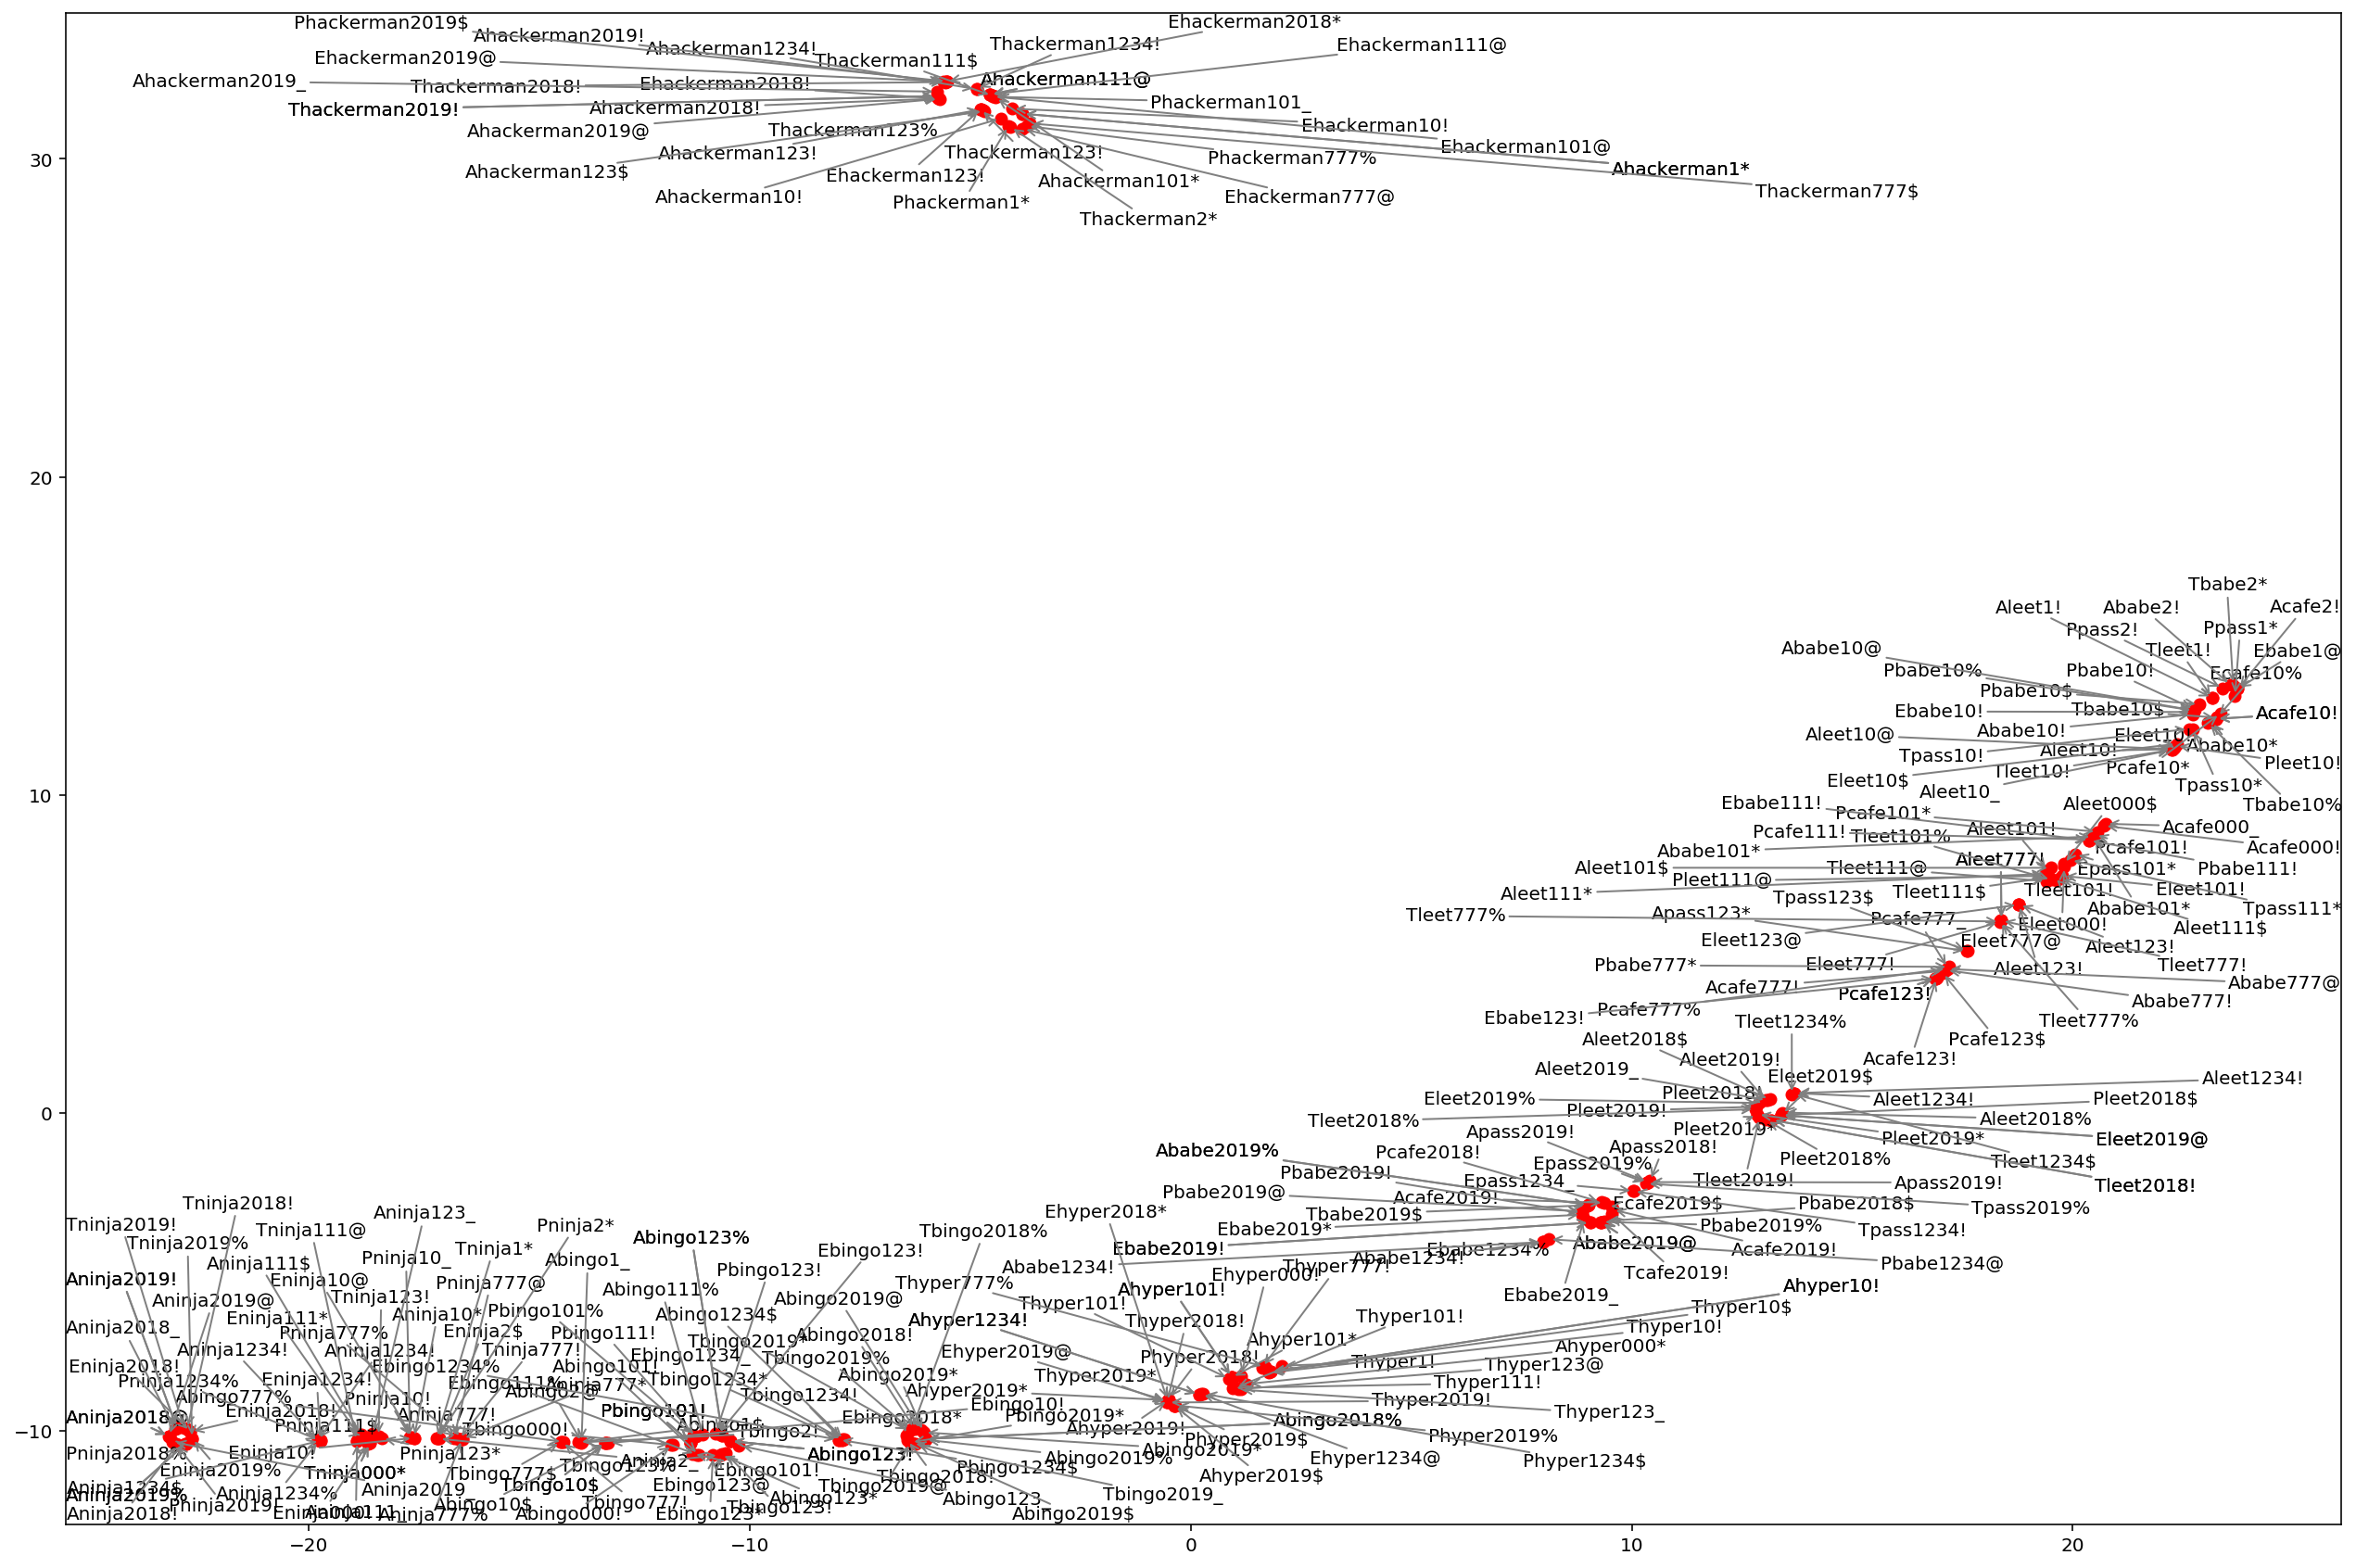

In [69]:
#############################################
###  Visualize Passowrds in Latent Space  ###
#############################################
%config InlineBackend.figure_format = 'retina'

from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, AnnotationBbox
from sklearn import manifold

def t_sne(latent_passwords, original_passwords, plot=True):
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(latent_passwords)
    if plot:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=(22,15))
        plt.plot(X_tsne[:, 0], X_tsne[:, 1], 'ro')
        texts = [plt.text(X_tsne[:, 0][i], X_tsne[:, 1][i], '%s' %original_passwords[i], ha='center', va='center') for i in range(len(original_passwords))]
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))
        plt.show()
    else:
        return X_tsne, tsne

limit = 300
latent_passwords = variational_encoder.predict(one_hot_encoded[:limit], batch_size=10)
t_sne(latent_passwords, passwords["FullPassword"][:limit])